In [355]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Text pre-processing
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk 
import contractions
import re

# Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

# GloVe
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

# Word2Vec
from gensim.models import KeyedVectors

# FastText
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

# BERT
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers import TextClassificationPipeline
from tqdm import tqdm
import torch
import pickle

# Multi-Class Text Classification for NASA DRF Service Descriptions

This notebook explores various NLP Models for classifying multi-class text data. We run experiments on 3 model architectures across 3 datasets to investigate performance based on different types of text.

## Exploring the Data

This section loads and outlines the 3 datasets.

In [27]:
# Helper functions

# Returns average, minimum, and maximum lengths of text
def get_lengths(data):
    avg_len, min_len, max_len = 0, np.inf, -1
    for example in data:
        length = len(example)
        avg_len += length
        if length < min_len:
            min_len = length
        if length > max_len:
            max_len = length
    avg_len /= len(data)
    return avg_len, min_len, max_len

# Creates a pie chart of the distribution of labels
def plot_distribution(data):
    counts = {}
    for example in data:
        if example in counts:
            counts[example] += 1
        else:
            counts[example] = 1
    plt.pie(counts.values(), labels=counts.keys())
    plt.show()

### Ecommerce Dataset
https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

This dataset contains 50,425 product descriptions categorized into one of four labels: Electronics, Household, Books, and Clothing & Accessories.

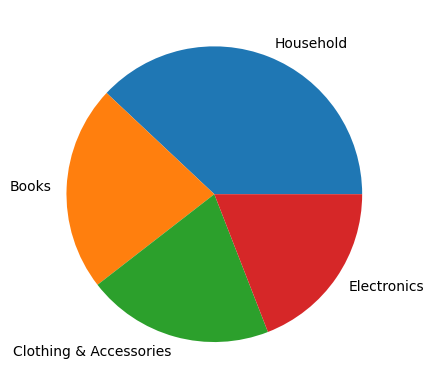

Average length: 699.9949284224157 
Min length: 4 
Max length: 50403


,description,Books,Clothing & Accessories,Electronics,Household
0,Paper Plane Design Framed Wall Hanging Motivat...,0,0,0,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",0,0,0,1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,0,0,0,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",0,0,0,1
4,Incredible Gifts India Wooden Happy Birthday U...,0,0,0,1
...,...,...,...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,0,0,1,0
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0,0,1,0
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0,0,1,0
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0,0,1,0


In [202]:
# Load the dataset
ecommerce_df = pd.read_csv("./ecommerceDataset.csv", names=["label", "description"])
ecommerce_df = ecommerce_df[["description", "label"]]

# Clean the data - drop duplicates and missing values
ecommerce_df.dropna(inplace=True)
ecommerce_df.drop_duplicates(inplace=True)
ecommerce_df.reset_index(drop=True, inplace=True)

# Plot distribution
plot_distribution(ecommerce_df["label"])

# Encoding for BERT
le_ecommerce = LabelEncoder()
ecommerce_text_bert = ecommerce_df["description"].map(str).values.tolist()
ecommerce_labels_bert = le_ecommerce.fit_transform(ecommerce_df["label"].values.tolist()).tolist()

# One hot encoding
ohe = pd.get_dummies(ecommerce_df["label"])
ecommerce_df = pd.concat([ecommerce_df["description"], ohe], axis=1)
ecommerce_encoding = ["Books", "Clothing & Accessories", "Electronics", "Household"]

# Explore lengths
ecommerce_lengths = get_lengths(ecommerce_df["description"])
print(f"Average length: {ecommerce_lengths[0]} \nMin length: {ecommerce_lengths[1]} \nMax length: {ecommerce_lengths[2]}")
ECOMMERCE_MAX_LENGTH = 1000

ecommerce_df

### Tweet Dataset
https://www.kaggle.com/datasets/ishantjuyal/emotions-in-text

This dataset contains 21,405 short texts categorized into one of six labels: anger, fear, happy, love, sadness, surprise.

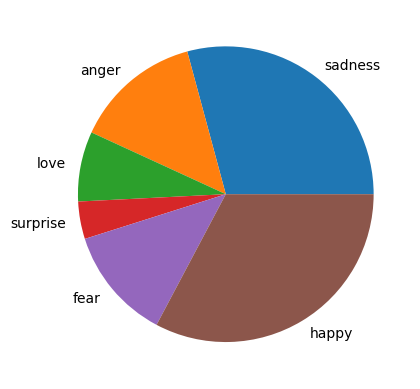

Average length: 96.71434563758389 
Min length: 7 
Max length: 307


,Text,anger,fear,happy,love,sadness,surprise
1,i didnt feel humiliated,0,0,0,0,1,0
2,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
3,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
4,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
5,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
21452,Melissa stared at her friend in dism,0,1,0,0,0,0
21453,Successive state elections have seen the gover...,0,1,0,0,0,0
21454,Vincent was irritated but not dismay,0,1,0,0,0,0
21455,Kendall-Hume turned back to face the dismayed ...,0,1,0,0,0,0


In [203]:
# Load the dataset
tweet_df = pd.read_csv("./Emotion_final.csv", names=["Text", "Emotion"])
tweet_df = tweet_df[["Text", "Emotion"]]

# Clean the data - drop duplicates and missing values
tweet_df.dropna(inplace=True)
tweet_df.drop_duplicates(inplace=True)
tweet_df.reset_index(drop=True, inplace=True)
tweet_df = tweet_df.tail(-1)

# Plot distribution
plot_distribution(tweet_df["Emotion"])

# Encoding for BERT
le_tweet = LabelEncoder()
tweet_text_bert = tweet_df["Text"].map(str).values.tolist()
tweet_labels_bert = le_tweet.fit_transform(tweet_df["Emotion"].values.tolist()).tolist()

# One hot encoding
ohe = pd.get_dummies(tweet_df["Emotion"])
tweet_df = pd.concat([tweet_df["Text"], ohe], axis=1)
tweet_encoding = ["anger", "fear", "happy", "love", "sadness", "surprise"]

# Explore lengths
tweet_lengths = get_lengths(tweet_df["Text"])
print(f"Average length: {tweet_lengths[0]} \nMin length: {tweet_lengths[1]} \nMax length: {tweet_lengths[2]}")
TWEET_MAX_LENGTH = 280

tweet_df

### DRF Services Dataset

This dataset contains 449 DRF service descriptions categorized into one of five labels: Ambiguous, Emergency, Flight Operations, Ground Operations, Weather.

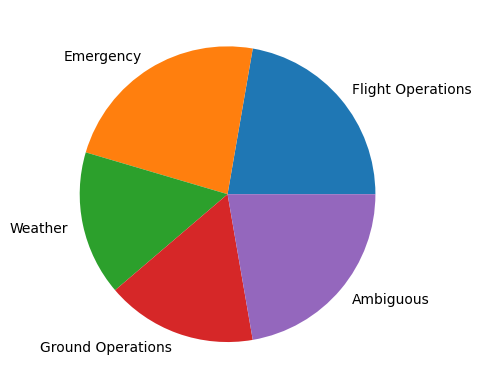

Average length: 198.71492204899778 
Min length: 98 
Max length: 320


,Service_Description,Ambiguous,Emergency,Flight Operations,Ground Operations,Weather
1,A Data Reasoning Fabric Service that provides ...,0,0,1,0,0
2,Our service provides emergency services to aut...,0,1,0,0,0
3,NightSky is a weather informational platform t...,0,0,0,0,1
4,A service that uses satellite imaging and mete...,0,1,0,0,0
5,Flight status and tracking service for deliver...,0,0,1,0,0
...,...,...,...,...,...,...
445,"center weather advisories (CWA), airmen’s mete...",0,0,0,0,1
446,"AIRMETs cover moderate icing, moderate turbule...",0,0,0,0,1
447,Such weather forecasts and warnings are produc...,0,0,0,0,1
448,In each country the national weather bureau st...,0,0,0,0,1


In [204]:
# Load the dataset
drf_df = pd.read_csv("./DRF_Services_Custom_Dataset.csv", names=["Timestamp", "Service_Title", "Service_Description", "Word_Count", "Label", "Numerical_Label"])
drf_df = drf_df[["Service_Description", "Label"]]

# Clean the data - drop duplicates and missing values
drf_df.dropna(inplace=True)
drf_df.drop_duplicates(inplace=True)
drf_df.reset_index(drop=True, inplace=True)
drf_df = drf_df.tail(-1)

# Plot distribution
plot_distribution(drf_df["Label"])

# Encoding for BERT
le_drf = LabelEncoder()
drf_text_bert = drf_df["Service_Description"].map(str).values.tolist()
drf_labels_bert = le_drf.fit_transform(drf_df["Label"].values.tolist()).tolist()

# One hot encoding
ohe = pd.get_dummies(drf_df["Label"])
drf_df = pd.concat([drf_df["Service_Description"], ohe], axis=1)
drf_encoding = ["Ambiguous", "Emergency", "Flight Operations", "Ground Operations", "Weather"]

# Explore lengths
drf_lengths = get_lengths(drf_df["Service_Description"])
print(f"Average length: {drf_lengths[0]} \nMin length: {drf_lengths[1]} \nMax length: {drf_lengths[2]}")
DRF_MAX_LENGTH = 320

drf_df

## Creating the Models

This section creates functions to build the 3 model architectures.

In [128]:
# Helper functions

VALIDATION_SPLIT=0.2

# Basic text normalization
def text_normalization(lines):
    sentences = list()
    for line in lines:   
        tokens = word_tokenize(line)
        tokens = [w.lower() for w in tokens]
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()] 
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        sentences.append(words)
    return sentences

# Split the data into a training set and a validation set
def split_data(padded_sequences, labels, validation_split=VALIDATION_SPLIT):
    indices = np.arange(padded_sequences.shape[0])
    np.random.shuffle(indices)
    padded_sequences = padded_sequences[indices]
    labels = labels[indices]
    num_validation_samples = int(validation_split * padded_sequences.shape[0])

    X_train_pad = padded_sequences[:-num_validation_samples]
    y_train = labels[:-num_validation_samples]
    X_test_pad = padded_sequences[-num_validation_samples:]
    y_test = labels[-num_validation_samples:]
    
    return X_train_pad, y_train, X_test_pad, y_test

# Return the word embedding matrix
def get_embedding_matrix(word_index, embedding_dim, trained_embedding_dictionary):
    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i > num_words:
            continue
        embedding_vector = trained_embedding_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, num_words

# Train the model
def train(num_words, embedding_matrix, data, num_outputs, batch_size, epochs, max_length, embedding_dim, callbacks=[]):
    model = Sequential()
    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=max_length,
                                trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print('Summary of the built model...')
    print(model.summary())

    X_train_pad, y_train, X_test_pad, y_test = data
    history = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad, y_test), callbacks=callbacks, verbose=2)
    
    return model, history

# Summarize history for accuracy and loss
def plot_accuracy_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


### GloVe + LSTM Model

In [197]:
# Helper functions

GLOVE_EMBEDDING_DIM = 50

# Vectorize the text samples into a 2D integer tensor
def vectorize_text(sentences, max_length):
    tokenizer_obj = Tokenizer() 
    tokenizer_obj.fit_on_texts(sentences)
    sequences = tokenizer_obj.texts_to_sequences(sentences)
    word_index = tokenizer_obj.word_index
    print('Found %s unique tokens.' % len(word_index))
    padded_sequences = pad_sequences(sequences, maxlen=max_length)
    return padded_sequences, word_index, tokenizer_obj

# Predict label for text
def predict(model, encoding, tokenizer_obj, max_length, text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    sequences = tokenizer_obj.texts_to_sequences([words])
    review_pad = pad_sequences(sequences, maxlen=max_length)

    probabilities = model.predict(review_pad, verbose=0)
    prediction = np.argmax(probabilities)

    return f'{encoding[prediction]} with probability {probabilities[0][prediction] * 100}%'
    
    
# Load glove embedding
# https://nlp.stanford.edu/projects/glove/
glove_embeddings_dict = {}
with open('glove/glove.6B/glove.6B.50d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove_embeddings_dict[word] = vector

#### Ecommerce Dataset

In [134]:
ecommerce_lines = ecommerce_df['description'].values.tolist()
ecommerce_sentences = text_normalization(ecommerce_lines)

ecommerce_sentences, ecommerce_word_index, ecommerce_tokenizer_glove = vectorize_text(ecommerce_sentences, max_length=ECOMMERCE_MAX_LENGTH)
ecommerce_labels = np.array((ecommerce_df['Books'].values, ecommerce_df['Clothing & Accessories'].values, ecommerce_df['Electronics'].values, ecommerce_df['Household'].values)).T
print('Shape of sentences tensor:', ecommerce_sentences.shape)
print('Shape of labels tensor:', ecommerce_labels.shape)

ecommerce_data = split_data(ecommerce_sentences, ecommerce_labels)

ecommerce_embedding_matrix, ecommerce_num_words = get_embedding_matrix(ecommerce_word_index, GLOVE_EMBEDDING_DIM, glove_embeddings_dict)

Found 78711 unique tokens.
Shape of sentences tensor: (27802, 1000)
Shape of labels tensor: (27802, 4)


Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          3935600   
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 3,946,356
Trainable params: 10,756
Non-trainable params: 3,935,600
_________________________________________________________________


2023-03-15 11:28:46.222343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/50
2225/2225 - 1360s - loss: 0.4338 - accuracy: 0.8649 - val_loss: 0.3394 - val_accuracy: 0.8926 - 1360s/epoch - 611ms/step
Epoch 2/50
2225/2225 - 1288s - loss: 0.3293 - accuracy: 0.9011 - val_loss: 0.2669 - val_accuracy: 0.9248 - 1288s/epoch - 579ms/step
Epoch 3/50
2225/2225 - 1297s - loss: 0.2861 - accuracy: 0.9176 - val_loss: 0.2494 - val_accuracy: 0.9273 - 1297s/epoch - 583ms/step
Epoch 4/50
2225/2225 - 1286s - loss: 0.2636 - accuracy: 0.9217 - val_loss: 0.2402 - val_accuracy: 0.9308 - 1286s/epoch - 578ms/step
Epoch 5/50
2225/2225 - 1311s - loss: 0.2493 - accuracy: 0.9257 - val_loss: 0.2407 - val_accuracy: 0.9308 - 1311s/epoch - 589ms/step
Epoch 6/50
2225/2225 - 1312s - loss: 0.2381 - accuracy: 0.9282 - val_loss: 0.2253 - val_accuracy: 0.9340 - 1312s/epoch - 590ms/step
Epoch 7/50
2225/2225 - 1269s - loss: 0.2245 - accuracy: 0.9333 - val_loss: 0.2253 - val_accuracy: 0.9326 - 1269s/epoch - 570ms/step
Epoch 8/50
2225/2225 - 1320s - loss: 0.2141 - accuracy: 0.9369 - val_lo

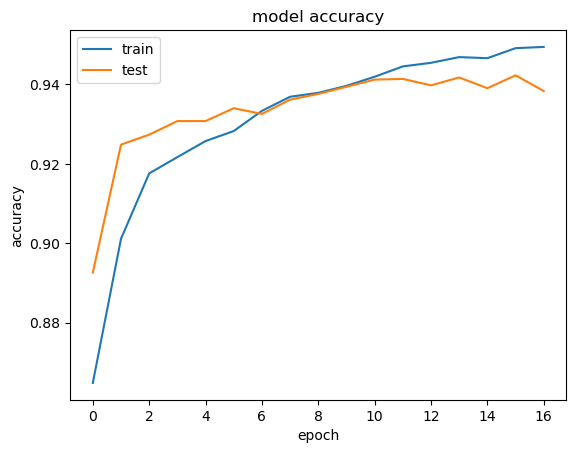

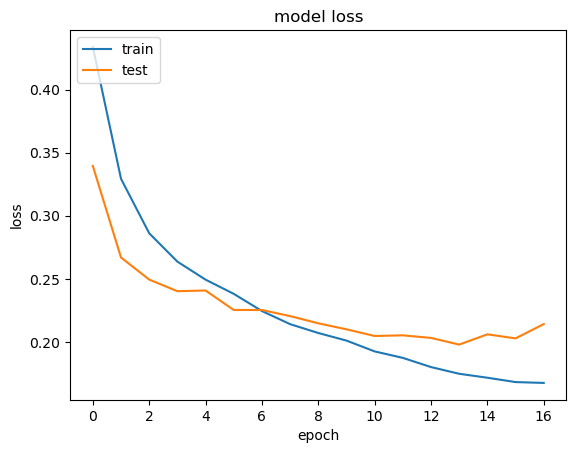

In [55]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

ecommerce_model_glove, ecommerce_history_glove = train(ecommerce_num_words, ecommerce_embedding_matrix, ecommerce_data, num_outputs=4, batch_size=10, epochs=50, max_length=ECOMMERCE_MAX_LENGTH, embedding_dim=GLOVE_EMBEDDING_DIM, callbacks=[es])

ecommerce_model_glove.save('glove/ecommerce_model')

plot_accuracy_loss(ecommerce_history_glove)

#### Tweet Dataset

In [130]:
tweet_lines = tweet_df['Text'].values.tolist()
for line in tweet_lines:
    line = re.sub(r'@[A-Za-z0-9]+', '', line) # remove @mentions
    line = re.sub(r'#', '', line)# remove # tag
    line = re.sub(r'RT[\s]+', '', line) # remove the RT
    line = re.sub(r'https?:\/\/\S+', '', line) # remove links
    line = re.sub('(\\\\u([a-z]|[0-9])+)', ' ', line) # remove unicode characters
    line = re.sub(r'"', '', line)
    line = re.sub(r':', '', line)
tweet_sentences = text_normalization(tweet_lines)

tweet_sentences, tweet_word_index, tweet_tokenizer_glove = vectorize_text(tweet_sentences, TWEET_MAX_LENGTH)
tweet_labels = np.array((tweet_df['anger'].values, tweet_df['fear'].values, 
                         tweet_df['happy'].values, tweet_df['love'].values, 
                         tweet_df['sadness'].values, tweet_df['surprise'].values)).T
print('Shape of sentences tensor:', tweet_sentences.shape)
print('Shape of labels tensor:', tweet_labels.shape)

tweet_data = split_data(tweet_sentences, tweet_labels)

tweet_embedding_matrix, tweet_num_words = get_embedding_matrix(tweet_word_index, GLOVE_EMBEDDING_DIM, glove_embeddings_dict)

Found 19104 unique tokens.
Shape of sentences tensor: (21456, 280)
Shape of labels tensor: (21456, 6)


Summary of the built model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 280, 50)           955250    
                                                                 
 lstm_2 (LSTM)               (None, 32)                10624     
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 966,072
Trainable params: 10,822
Non-trainable params: 955,250
_________________________________________________________________
None
Epoch 1/50
1717/1717 - 276s - loss: 1.3558 - accuracy: 0.4840 - val_loss: 1.0701 - val_accuracy: 0.6034 - 276s/epoch - 161ms/step
Epoch 2/50
1717/1717 - 272s - loss: 1.0528 - accuracy: 0.6064 - val_loss: 0.8445 - val_accuracy: 0.6842 - 272s/epoch - 159ms/step
Epoch 3/50
1

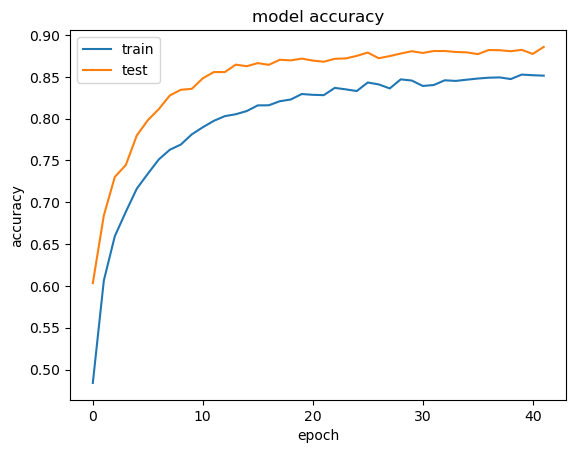

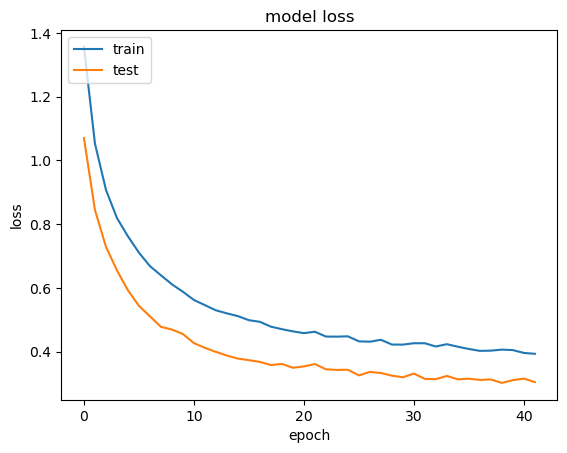

In [73]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

tweet_model_glove, tweet_history_glove = train(tweet_num_words, tweet_embedding_matrix, tweet_data, num_outputs=6, batch_size=10, epochs=50, max_length=TWEET_MAX_LENGTH, embedding_dim=GLOVE_EMBEDDING_DIM, callbacks=[es])

tweet_model_glove.save('glove/tweet_model')

plot_accuracy_loss(tweet_history_glove)

#### DRF Services Dataset

In [131]:
drf_lines = drf_df['Service_Description'].values.tolist()
drf_sentences = text_normalization(drf_lines)

drf_sentences, drf_word_index, drf_tokenizer_glove = vectorize_text(drf_sentences, DRF_MAX_LENGTH)
drf_labels = np.array((drf_df["Ambiguous"].values, drf_df["Emergency"].values, drf_df["Flight Operations"].values, drf_df["Ground Operations"].values, drf_df["Weather"].values)).T
print('Shape of sentences tensor:', drf_sentences.shape)
print('Shape of labels tensor:', drf_labels.shape)

drf_data = split_data(drf_sentences, drf_labels)

drf_embedding_matrix, drf_num_words = get_embedding_matrix(drf_word_index, GLOVE_EMBEDDING_DIM, glove_embeddings_dict)

Found 2928 unique tokens.
Shape of sentences tensor: (449, 320)
Shape of labels tensor: (449, 5)


Summary of the built model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 320, 50)           146450    
                                                                 
 lstm_4 (LSTM)               (None, 32)                10624     
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                                 
Total params: 157,239
Trainable params: 10,789
Non-trainable params: 146,450
_________________________________________________________________
None
Epoch 1/50
36/36 - 5s - loss: 1.5240 - accuracy: 0.4056 - val_loss: 1.4046 - val_accuracy: 0.4607 - 5s/epoch - 151ms/step
Epoch 2/50
36/36 - 4s - loss: 1.2203 - accuracy: 0.6417 - val_loss: 1.1256 - val_accuracy: 0.5393 - 4s/epoch - 103ms/step
Epoch 3/50
36/36 - 4s - loss

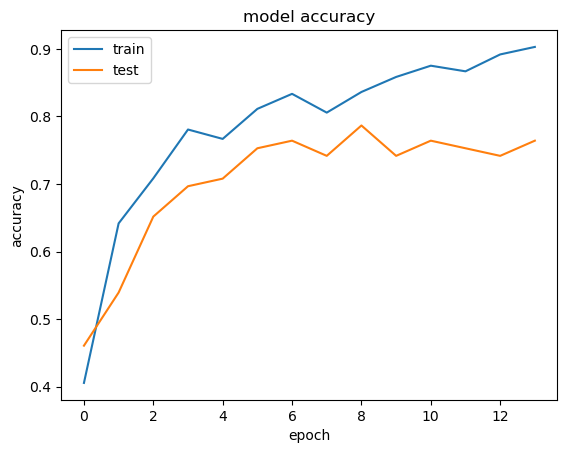

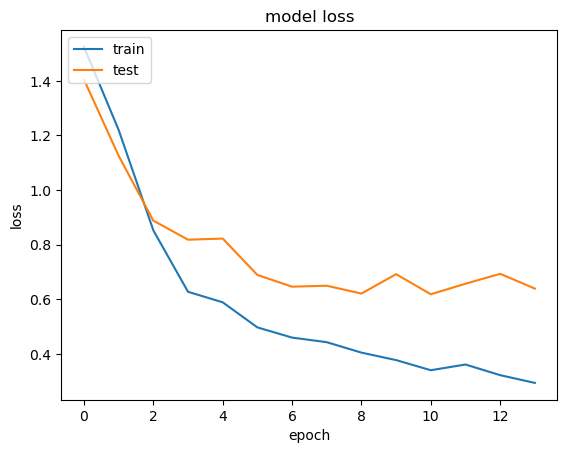

In [76]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

drf_model_glove, drf_history_glove = train(drf_num_words, drf_embedding_matrix, drf_data, num_outputs=5, batch_size=10, epochs=50, max_length=DRF_MAX_LENGTH, embedding_dim=GLOVE_EMBEDDING_DIM, callbacks=[es])

drf_model_glove.save('glove/drf_model')

plot_accuracy_loss(drf_history_glove)

#### Save GloVe Tokenizers

In [359]:
with open(f'glove/ecommerce_tokenizer.pickle', 'wb') as handle:
    pickle.dump(ecommerce_tokenizer_glove, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'glove/tweet_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tweet_tokenizer_glove, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'glove/drf_tokenizer.pickle', 'wb') as handle:
    pickle.dump(drf_tokenizer_glove, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Word2Vec + LSTM Model

In [123]:
# Helper functions

WORD2VEC_EMBEDDING_DIM = 300

# Tokenize the text
def tokenize_text(cleaned_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(cleaned_data)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    return word_index, tokenizer

# Predict label for text
def test_model(model, encoding, tokenizer, max_length, text):
  # removes punctuation in the sentence
  text = re.sub(r'[^\w\s]', '', text)
  # gets all of the words in the sentence 
  words = word_tokenize(text) 
  # converts all the words to lowercase
  words = [w.lower() for w in words]
  # retrieves a set of all of the stopwords in English 
  stop_words = set(stopwords.words('english'))
  # removes the stopwords in the sentence
  words = [w for w in words if not w in stop_words]

  sequences = tokenizer.texts_to_sequences([words])
  review_pad = pad_sequences(sequences, maxlen=max_length)
    
  probabilities = model.predict(review_pad, verbose=0)
  prediction = np.argmax(probabilities)

  return f'{encoding[prediction]} with probability {probabilities[0][prediction] * 100}%'

# Use word2vec and get pretrained word embeddings 
# https://code.google.com/archive/p/word2vec/
word2vec_model = KeyedVectors.load_word2vec_format('./wiki-news-300d-1M.vec')
word2vec_embedding_dict = {}

for x in word2vec_model.key_to_index:
  word2vec_embedding_dict[x] = word2vec_model.get_vector(x)

#### Ecommerce Dataset

In [83]:
ecommerce_lines = ecommerce_df['description'].values.tolist()  
ecommerce_cleaned_data = text_normalization(ecommerce_lines)

ecommerce_word_index, ecommerce_tokenizer = tokenize_text(ecommerce_cleaned_data)
ecommerce_embedding_matrix, ecommerce_num_words = get_embedding_matrix(ecommerce_word_index, WORD2VEC_EMBEDDING_DIM, word2vec_embedding_dict)

ecommerce_sequences = ecommerce_tokenizer.texts_to_sequences(ecommerce_cleaned_data)

ecommerce_sentences = pad_sequences(ecommerce_sequences, maxlen=ECOMMERCE_MAX_LENGTH) # to later try - base length on mean value of sentence lengths 
ecommerce_labels = np.array((ecommerce_df['Books'].values, ecommerce_df['Clothing & Accessories'].values, ecommerce_df['Electronics'].values, ecommerce_df['Household'].values)).T
print('Shape of urgency tensor:', ecommerce_sentences.shape)
print('Shape of label tensor:', ecommerce_labels.shape)

ecommerce_data = split_data(ecommerce_sentences, ecommerce_labels)

Found 78711 unique tokens.
Shape of urgency tensor: (27802, 1000)
Shape of label tensor: (27802, 4)


Summary of the built model...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1000, 300)         23613600  
                                                                 
 lstm_5 (LSTM)               (None, 32)                42624     
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 23,656,356
Trainable params: 42,756
Non-trainable params: 23,613,600
_________________________________________________________________
None
Epoch 1/50
2225/2225 - 1517s - loss: 0.4217 - accuracy: 0.8753 - val_loss: 0.3025 - val_accuracy: 0.9180 - 1517s/epoch - 682ms/step
Epoch 2/50
2225/2225 - 1510s - loss: 0.3108 - accuracy: 0.9140 - val_loss: 0.2826 - val_accuracy: 0.9194 - 1510s/epoch - 679ms/step
Ep

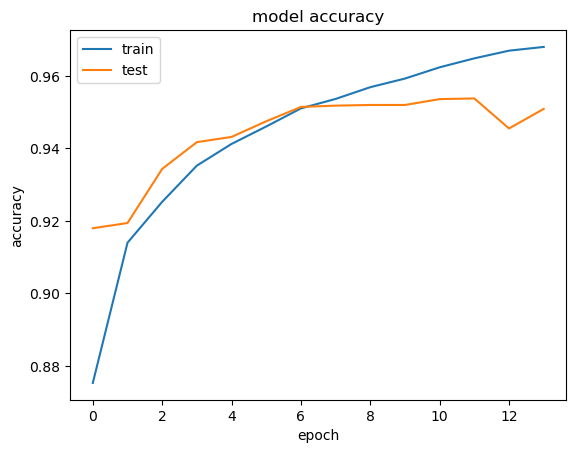

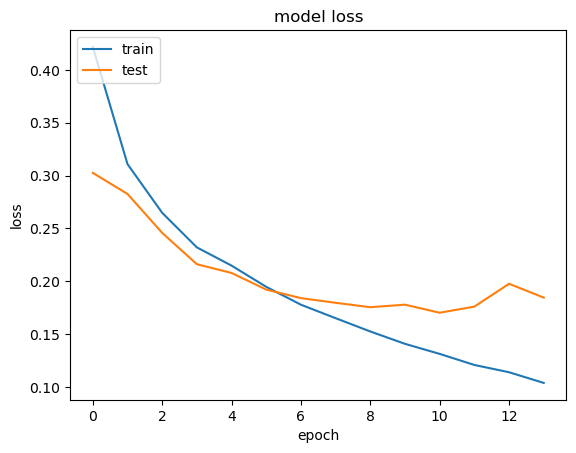

In [84]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

ecommerce_model_word2vec, ecommerce_history_word2vec = train(ecommerce_num_words, ecommerce_embedding_matrix, ecommerce_data, num_outputs=4, batch_size=10, epochs=50, max_length=ECOMMERCE_MAX_LENGTH, embedding_dim=WORD2VEC_EMBEDDING_DIM, callbacks=[es])

ecommerce_model_word2vec.save('word2vec/ecommerce_model')

plot_accuracy_loss(ecommerce_history_word2vec)

#### Tweet Dataset

In [85]:
tweet_lines = tweet_df['Text'].values.tolist()
for line in tweet_lines:
    line = re.sub(r'@[A-Za-z0-9]+', '', line) # remove @mentions
    line = re.sub(r'#', '', line)# remove # tag
    line = re.sub(r'RT[\s]+', '', line) # remove the RT
    line = re.sub(r'https?:\/\/\S+', '', line) # remove links
    line = re.sub('(\\\\u([a-z]|[0-9])+)', ' ', line) # remove unicode characters
    line = re.sub(r'"', '', line)
    line = re.sub(r':', '', line)
tweet_cleaned_data = text_normalization(tweet_lines)

tweet_word_index, tweet_tokenizer = tokenize_text(tweet_cleaned_data)
tweet_embedding_matrix, tweet_num_words = get_embedding_matrix(tweet_word_index, WORD2VEC_EMBEDDING_DIM, word2vec_embedding_dict)

tweet_sequences = tweet_tokenizer.texts_to_sequences(tweet_cleaned_data)

tweet_sentences = pad_sequences(tweet_sequences, maxlen=TWEET_MAX_LENGTH) # to later try - base length on mean value of sentence lengths 
tweet_labels = np.array((tweet_df['anger'].values, tweet_df['fear'].values, 
                         tweet_df['happy'].values, tweet_df['love'].values, 
                         tweet_df['sadness'].values, tweet_df['surprise'].values)).T
print('Shape of urgency tensor:', tweet_sentences.shape)
print('Shape of label tensor:', tweet_labels.shape)

tweet_data = split_data(tweet_sentences, tweet_labels)

Found 19104 unique tokens.
Shape of urgency tensor: (21456, 280)
Shape of label tensor: (21456, 6)


Summary of the built model...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 280, 300)          5731500   
                                                                 
 lstm_6 (LSTM)               (None, 32)                42624     
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                                 
Total params: 5,774,322
Trainable params: 42,822
Non-trainable params: 5,731,500
_________________________________________________________________
None
Epoch 1/50
1717/1717 - 324s - loss: 0.9802 - accuracy: 0.6503 - val_loss: 0.6069 - val_accuracy: 0.7837 - 324s/epoch - 189ms/step
Epoch 2/50
1717/1717 - 310s - loss: 0.5185 - accuracy: 0.8143 - val_loss: 0.3845 - val_accuracy: 0.8648 - 310s/epoch - 180ms/step
Epoch 3/

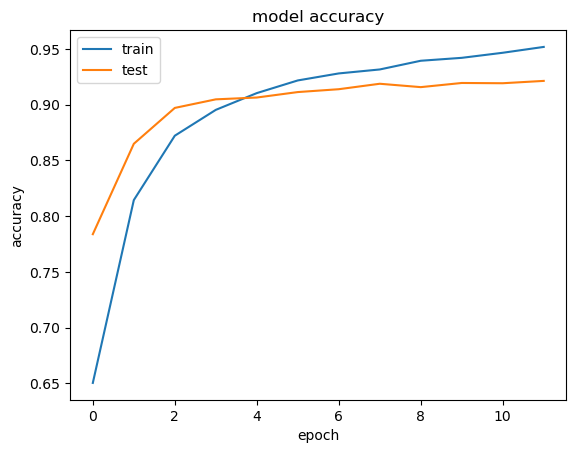

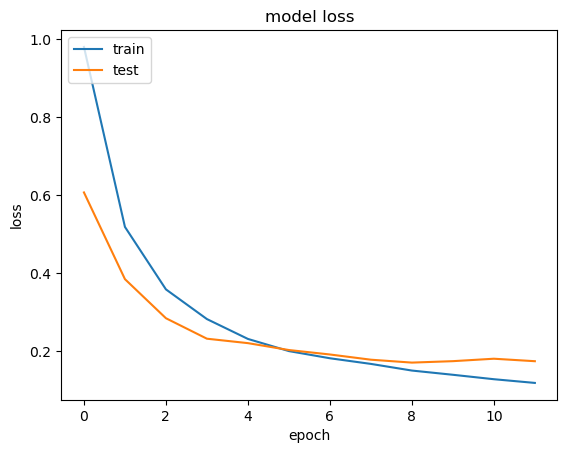

In [86]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

tweet_model_word2vec, tweet_history_word2vec = train(tweet_num_words, tweet_embedding_matrix, tweet_data, num_outputs=6, batch_size=10, epochs=50, max_length=TWEET_MAX_LENGTH, embedding_dim=WORD2VEC_EMBEDDING_DIM, callbacks=[es])

tweet_model_word2vec.save('word2vec/tweet_model')

plot_accuracy_loss(tweet_history_word2vec)

#### DRF Services Dataset

In [87]:
drf_lines = drf_df['Service_Description'].values.tolist()  
drf_cleaned_data = text_normalization(drf_lines)

drf_word_index, drf_tokenizer = tokenize_text(drf_cleaned_data)
drf_embedding_matrix, drf_num_words = get_embedding_matrix(drf_word_index, WORD2VEC_EMBEDDING_DIM, word2vec_embedding_dict)

drf_sequences = drf_tokenizer.texts_to_sequences(drf_cleaned_data)

drf_sentences = pad_sequences(drf_sequences, maxlen=DRF_MAX_LENGTH) # to later try - base length on mean value of sentence lengths 
drf_labels = np.array((drf_df["Ambiguous"].values, drf_df["Emergency"].values, drf_df["Flight Operations"].values, drf_df["Ground Operations"].values, drf_df["Weather"].values)).T
print('Shape of urgency tensor:', drf_sentences.shape)
print('Shape of label tensor:', drf_labels.shape)

drf_data = split_data(drf_sentences, drf_labels)

Found 2928 unique tokens.
Shape of urgency tensor: (449, 320)
Shape of label tensor: (449, 5)


Summary of the built model...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 320, 300)          878700    
                                                                 
 lstm_7 (LSTM)               (None, 32)                42624     
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 921,489
Trainable params: 42,789
Non-trainable params: 878,700
_________________________________________________________________
None
Epoch 1/50
36/36 - 6s - loss: 1.5031 - accuracy: 0.4139 - val_loss: 1.4155 - val_accuracy: 0.3708 - 6s/epoch - 165ms/step
Epoch 2/50
36/36 - 4s - loss: 1.0661 - accuracy: 0.5278 - val_loss: 1.0402 - val_accuracy: 0.6180 - 4s/epoch - 125ms/step
Epoch 3/50
36/36 - 5s - loss

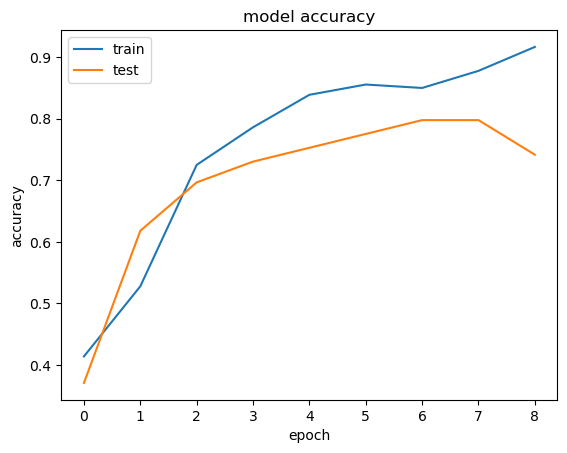

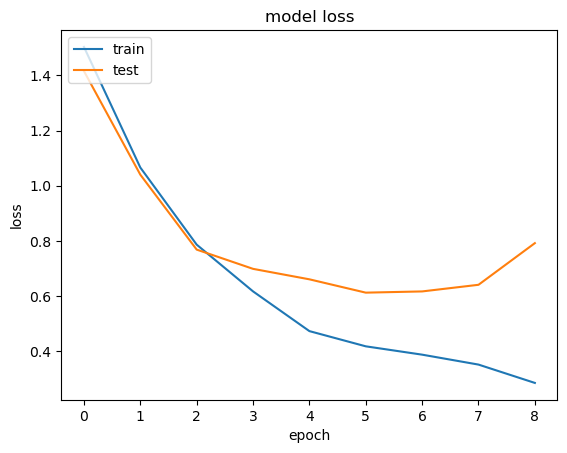

In [88]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

drf_model_word2vec, drf_history_word2vec = train(drf_num_words, drf_embedding_matrix, drf_data, num_outputs=5, batch_size=10, epochs=50, max_length=DRF_MAX_LENGTH, embedding_dim=WORD2VEC_EMBEDDING_DIM, callbacks=[es])

drf_model_word2vec.save('word2vec/drf_model')

plot_accuracy_loss(drf_history_word2vec)

#### Save Word2Vec Tokenizers

In [358]:
with open(f'word2vec/ecommerce_tokenizer.pickle', 'wb') as handle:
    pickle.dump(ecommerce_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'word2vec/tweet_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tweet_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'word2vec/drf_tokenizer.pickle', 'wb') as handle:
    pickle.dump(drf_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### FastText + LSTM Model

In [95]:
# FastText corpus

FASTTEXT_EMBEDDING_DIM = 300

corpus_file = datapath('lee_background.cor')

fasttext_model = FastText(vector_size=300, window=10, sample=1e-2, sg=1)  # instantiate
fasttext_model.build_vocab(corpus_file=corpus_file)
fasttext_model.train(corpus_file=corpus_file, total_words=fasttext_model.corpus_total_words, epochs=5)

def get_embedding_matrix(word_index, fasttext_model):
    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, 300))

    for word, i in word_index.items():
        if i > num_words:
            continue
        embedding_vector = fasttext_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix, num_words

#### Ecommerce Dataset

In [96]:
ecommerce_lines = ecommerce_df['description'].values.tolist()  
ecommerce_cleaned_data = text_normalization(ecommerce_lines)

ecommerce_word_index, ecommerce_tokenizer = tokenize_text(ecommerce_cleaned_data)
ecommerce_embedding_matrix, ecommerce_num_words = get_embedding_matrix(ecommerce_word_index, fasttext_model)

ecommerce_sequences = ecommerce_tokenizer.texts_to_sequences(ecommerce_cleaned_data)

ecommerce_sentences = pad_sequences(ecommerce_sequences, maxlen=ECOMMERCE_MAX_LENGTH) # to later try - base length on mean value of sentence lengths 
ecommerce_labels = np.array((ecommerce_df['Books'].values, ecommerce_df['Clothing & Accessories'].values, ecommerce_df['Electronics'].values, ecommerce_df['Household'].values)).T
print('Shape of urgency tensor:', ecommerce_sentences.shape)
print('Shape of label tensor:', ecommerce_labels.shape)

ecommerce_data = split_data(ecommerce_sentences, ecommerce_labels)

Found 78711 unique tokens.
Shape of urgency tensor: (27802, 1000)
Shape of label tensor: (27802, 4)


Summary of the built model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1000, 300)         23613600  
                                                                 
 lstm_8 (LSTM)               (None, 32)                42624     
                                                                 
 dense_8 (Dense)             (None, 4)                 132       
                                                                 
Total params: 23,656,356
Trainable params: 42,756
Non-trainable params: 23,613,600
_________________________________________________________________
None
Epoch 1/50
2225/2225 - 1509s - loss: 1.2210 - accuracy: 0.4545 - val_loss: 1.0971 - val_accuracy: 0.5363 - 1509s/epoch - 678ms/step
Epoch 2/50
2225/2225 - 1508s - loss: 1.0533 - accuracy: 0.5525 - val_loss: 0.9877 - val_accuracy: 0.5912 - 1508s/epoch - 678ms/step
E

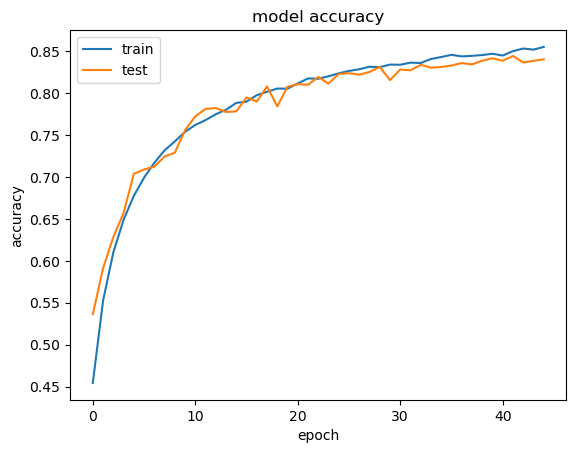

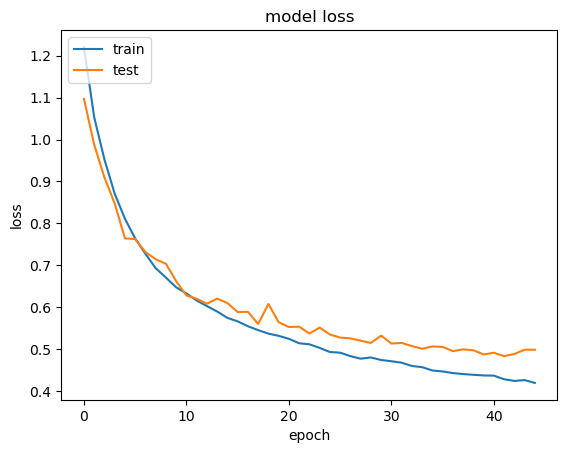

In [99]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

ecommerce_model_fasttext, ecommerce_history_fasttext = train(ecommerce_num_words, ecommerce_embedding_matrix, ecommerce_data, num_outputs=4, batch_size=10, epochs=50, max_length=ECOMMERCE_MAX_LENGTH, embedding_dim=FASTTEXT_EMBEDDING_DIM, callbacks=[es])

ecommerce_model_fasttext.save('fasttext/ecommerce_model')

plot_accuracy_loss(ecommerce_history_fasttext)

#### Tweet Dataset

In [97]:
tweet_lines = tweet_df['Text'].values.tolist()
for line in tweet_lines:
    line = re.sub(r'@[A-Za-z0-9]+', '', line) # remove @mentions
    line = re.sub(r'#', '', line)# remove # tag
    line = re.sub(r'RT[\s]+', '', line) # remove the RT
    line = re.sub(r'https?:\/\/\S+', '', line) # remove links
    line = re.sub('(\\\\u([a-z]|[0-9])+)', ' ', line) # remove unicode characters
    line = re.sub(r'"', '', line)
    line = re.sub(r':', '', line)
tweet_cleaned_data = text_normalization(tweet_lines)

tweet_word_index, tweet_tokenizer = tokenize_text(tweet_cleaned_data)
tweet_embedding_matrix, tweet_num_words = get_embedding_matrix(tweet_word_index, fasttext_model)

tweet_sequences = tweet_tokenizer.texts_to_sequences(tweet_cleaned_data)

tweet_sentences = pad_sequences(tweet_sequences, maxlen=TWEET_MAX_LENGTH) # to later try - base length on mean value of sentence lengths 
tweet_labels = np.array((tweet_df['anger'].values, tweet_df['fear'].values, 
                         tweet_df['happy'].values, tweet_df['love'].values, 
                         tweet_df['sadness'].values, tweet_df['surprise'].values)).T
print('Shape of urgency tensor:', tweet_sentences.shape)
print('Shape of label tensor:', tweet_labels.shape)

tweet_data = split_data(tweet_sentences, tweet_labels)

Found 19104 unique tokens.
Shape of urgency tensor: (21456, 280)
Shape of label tensor: (21456, 6)


Summary of the built model...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 280, 300)          5731500   
                                                                 
 lstm_9 (LSTM)               (None, 32)                42624     
                                                                 
 dense_9 (Dense)             (None, 6)                 198       
                                                                 
Total params: 5,774,322
Trainable params: 42,822
Non-trainable params: 5,731,500
_________________________________________________________________
None
Epoch 1/50
1717/1717 - 337s - loss: 1.5908 - accuracy: 0.3292 - val_loss: 1.5687 - val_accuracy: 0.3526 - 337s/epoch - 196ms/step
Epoch 2/50
1717/1717 - 311s - loss: 1.5817 - accuracy: 0.3377 - val_loss: 1.5547 - val_accuracy: 0.3500 - 311s/epoch - 181ms/step
Epoch 3

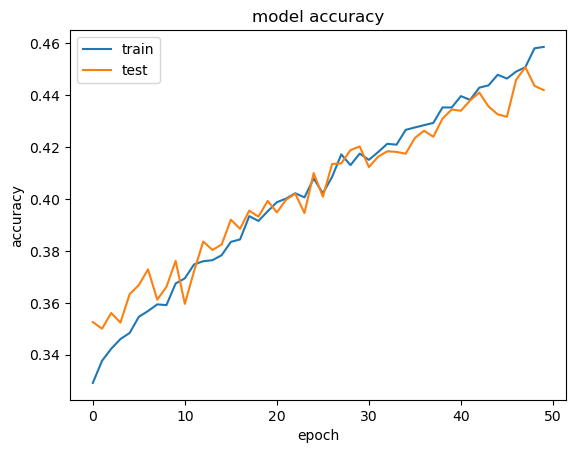

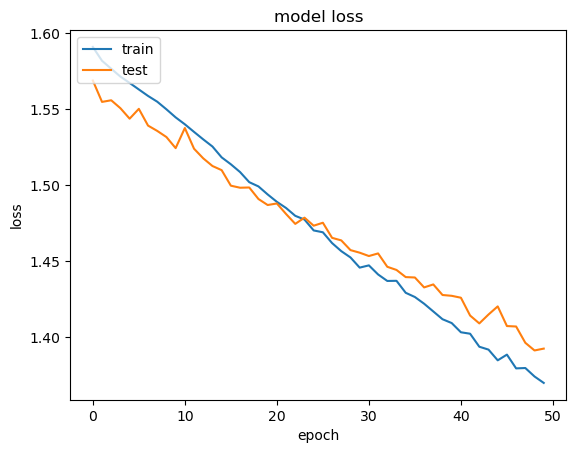

In [100]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

tweet_model_fasttext, tweet_history_fasttext = train(tweet_num_words, tweet_embedding_matrix, tweet_data, num_outputs=6, batch_size=10, epochs=50, max_length=TWEET_MAX_LENGTH, embedding_dim=FASTTEXT_EMBEDDING_DIM, callbacks=[es])

tweet_model_fasttext.save('fasttext/tweet_model')

plot_accuracy_loss(tweet_history_fasttext)

#### DRF Services Dataset

In [98]:
drf_lines = drf_df['Service_Description'].values.tolist()  
drf_cleaned_data = text_normalization(drf_lines)

drf_word_index, drf_tokenizer = tokenize_text(drf_cleaned_data)
drf_embedding_matrix, drf_num_words = get_embedding_matrix(drf_word_index, fasttext_model)

drf_sequences = drf_tokenizer.texts_to_sequences(drf_cleaned_data)

drf_sentences = pad_sequences(drf_sequences, maxlen=DRF_MAX_LENGTH) # to later try - base length on mean value of sentence lengths 
drf_labels = np.array((drf_df["Ambiguous"].values, drf_df["Emergency"].values, drf_df["Flight Operations"].values, drf_df["Ground Operations"].values, drf_df["Weather"].values)).T
print('Shape of urgency tensor:', drf_sentences.shape)
print('Shape of label tensor:', drf_labels.shape)

drf_data = split_data(drf_sentences, drf_labels)

Found 2928 unique tokens.
Shape of urgency tensor: (449, 320)
Shape of label tensor: (449, 5)


Summary of the built model...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 320, 300)          878700    
                                                                 
 lstm_10 (LSTM)              (None, 32)                42624     
                                                                 
 dense_10 (Dense)            (None, 5)                 165       
                                                                 
Total params: 921,489
Trainable params: 42,789
Non-trainable params: 878,700
_________________________________________________________________
None
Epoch 1/50
36/36 - 6s - loss: 1.5966 - accuracy: 0.2417 - val_loss: 1.6579 - val_accuracy: 0.2697 - 6s/epoch - 168ms/step
Epoch 2/50
36/36 - 4s - loss: 1.5688 - accuracy: 0.3083 - val_loss: 1.6091 - val_accuracy: 0.2022 - 4s/epoch - 124ms/step
Epoch 3/50
36/36 - 5s - los

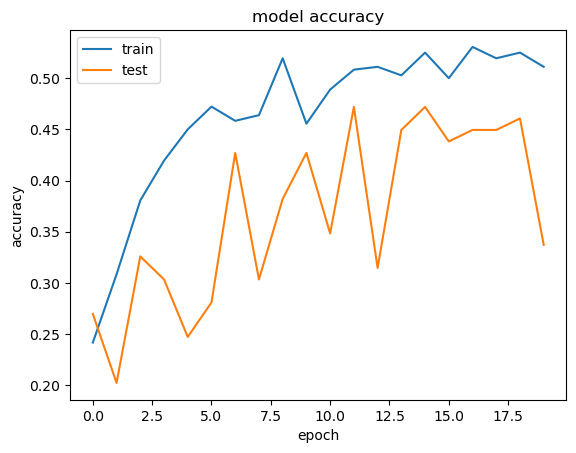

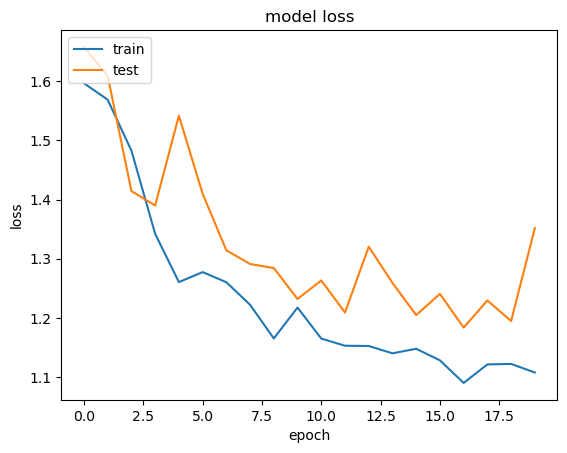

In [101]:
# Train the model
es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

drf_model_fasttext, drf_history_fasttext = train(drf_num_words, drf_embedding_matrix, drf_data, num_outputs=5, batch_size=10, epochs=50, max_length=DRF_MAX_LENGTH, embedding_dim=FASTTEXT_EMBEDDING_DIM, callbacks=[es])

drf_model_fasttext.save('fasttext/drf_model')

plot_accuracy_loss(drf_history_fasttext)

#### Save FastText Tokenizers

In [357]:
with open(f'fasttext/ecommerce_tokenizer.pickle', 'wb') as handle:
    pickle.dump(ecommerce_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'fasttext/tweet_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tweet_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'fasttext/drf_tokenizer.pickle', 'wb') as handle:
    pickle.dump(drf_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### BERT

In [369]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Wrapper class for dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val
                in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
# Return model for a specific number of classes
def get_model(num_labels):
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model

# Return batch tokenizer
def get_batch_tokenizer(tokenizer, dataset):
    return tokenizer.batch_encode_plus(dataset,
                                       max_length=256,
                                       padding=True,
                                       truncation=True,
                                       add_special_tokens=True,
                                       return_attention_mask=True,
                                       return_tensors='pt')

# Split data function specific to BERT
def split_data(tokenizer, text, labels, test_size=VALIDATION_SPLIT):
    x_train, x_test, y_train, y_test = train_test_split(text, labels, test_size=test_size, random_state=42)

    x_train_tokens = get_batch_tokenizer(tokenizer, x_train)
    x_test_tokens = get_batch_tokenizer(tokenizer, x_test)

    train_dataset = Dataset(x_train_tokens, y_train)
    test_dataset = Dataset(x_test_tokens, y_test)
    
    return train_dataset, test_dataset

# Compute accuracy score as metric
def compute_metrics(p):
    prediction, labels = p
    preds_flat = np.argmax(prediction, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = accuracy_score(labels_flat, preds_flat)
    return {"eval_accuracy": accuracy}

# Train dataset
def train(train_dataset, test_dataset, model, compute_metrics=compute_metrics):
    args = TrainingArguments(output_dir="output",
                             evaluation_strategy="epoch",
                             metric_for_best_model="eval_accuracy",
                             save_strategy="epoch",
                             num_train_epochs=50,
                             per_device_train_batch_size=10,
                             per_device_eval_batch_size=10,
                             load_best_model_at_end=True
                            )
    trainer = Trainer(args=args,
                        model=model,
                        train_dataset=train_dataset,
                        eval_dataset=test_dataset,
                        compute_metrics=compute_metrics,
                        callbacks=[EarlyStoppingCallback(
                                early_stopping_patience=3)]
                        )
    trainer.train()
    return trainer

# Predict class
def predict_bert(tokenizer, text, model, encoding):
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)
    probabilities = sorted(pipe(text, top_k=None), key=lambda d: d["label"])
    prediction = np.argmax([x["score"] for x in probabilities])
    return f'{encoding[prediction]} with score {probabilities[prediction]["score"]*100}%'

loading file vocab.txt from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_

#### Ecommerce Dataset

In [309]:
train_dataset, test_dataset = split_data(bert_tokenizer, ecommerce_text_bert, ecommerce_labels_bert)
ecommerce_model_bert = get_model(num_labels=4)
ecommerce_trainer_bert = train(train_dataset, test_dataset, ecommerce_model_bert)
ecommerce_trainer_bert.save_model('bert/ecommerce_model')

loading configuration file config.json from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading

Epoch,Training Loss,Validation Loss,Accuracy
1,0.249600,0.272065,0.936882
2,0.180500,0.237649,0.959180
3,0.113900,0.264190,0.952886
4,0.123600,0.244644,0.962237
5,0.090900,0.275564,0.957921
6,0.083000,0.256471,0.963136
7,0.074000,0.256559,0.960978
8,0.040400,0.292499,0.960619
9,0.068700,0.279249,0.959899


***** Running Evaluation *****
  Num examples = 5561
  Batch size = 10
Saving model checkpoint to output/checkpoint-2225
Configuration saved in output/checkpoint-2225/config.json
Model weights saved in output/checkpoint-2225/pytorch_model.bin
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_65370/3993764914.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val
***** Running Evaluation *****
  Num examples = 5561
  Batch size = 10
Saving model checkpoint to output/checkpoint-4450
Configuration saved in output/checkpoint-4450/config.json
Model weights saved in output/checkpoint-4450/pytorch_model.bin
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_65370/3993764914.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

#### Tweet Dataset

In [310]:
train_dataset, test_dataset = split_data(bert_tokenizer, tweet_text_bert, tweet_labels_bert)
tweet_model_bert = get_model(num_labels=6)
tweet_trainer_bert = train(train_dataset, test_dataset, tweet_model_bert)
tweet_trainer_bert.save_model('bert/tweet_model')

loading configuration file config.json from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.304600,0.253585,0.921016
2,0.207000,0.233267,0.929637
3,0.178300,0.212858,0.937791
4,0.157600,0.258719,0.932665
5,0.130700,0.407537,0.926841
6,0.077600,0.445705,0.931966


***** Running Evaluation *****
  Num examples = 4292
  Batch size = 10
Saving model checkpoint to output/checkpoint-1717
Configuration saved in output/checkpoint-1717/config.json
Model weights saved in output/checkpoint-1717/pytorch_model.bin
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_65370/3993764914.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val
***** Running Evaluation *****
  Num examples = 4292
  Batch size = 10
Saving model checkpoint to output/checkpoint-3434
Configuration saved in output/checkpoint-3434/config.json
Model weights saved in output/checkpoint-3434/pytorch_model.bin
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_65370/3993764914.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

#### DRF Services Dataset

In [311]:
train_dataset, test_dataset = split_data(bert_tokenizer, drf_text_bert, drf_labels_bert)
drf_model_bert = get_model(5)
drf_trainer_bert = train(train_dataset, test_dataset, drf_model_bert)
drf_trainer_bert.save_model('bert/drf_model')

loading configuration file config.json from cache at /Users/aszeto1/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.715909,0.755556
2,No log,0.553795,0.800000
3,No log,0.711078,0.777778
4,No log,0.947921,0.788889
5,No log,1.294114,0.777778


***** Running Evaluation *****
  Num examples = 90
  Batch size = 10
Saving model checkpoint to output/checkpoint-36
Configuration saved in output/checkpoint-36/config.json
Model weights saved in output/checkpoint-36/pytorch_model.bin
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_65370/3993764914.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val
***** Running Evaluation *****
  Num examples = 90
  Batch size = 10
Saving model checkpoint to output/checkpoint-72
Configuration saved in output/checkpoint-72/config.json
Model weights saved in output/checkpoint-72/pytorch_model.bin
/var/folders/yt/n8bqlxbn4xxfhgzf10hjdvtr0000gp/T/ipykernel_65370/3993764914.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

#### Save BERT Tokenizers

In [361]:
with open(f'bert/ecommerce_tokenizer.pickle', 'wb') as handle:
    pickle.dump(bert_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'bert/tweet_tokenizer.pickle', 'wb') as handle:
    pickle.dump(bert_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'bert/drf_tokenizer.pickle', 'wb') as handle:
    pickle.dump(bert_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Inference and Analysis

### Predictions Across Models

In [370]:
# Ecommerce Dataset Samples
ecommerce_test_samples = {"Table Lamp with Pull Chain: The USB Bedside Table Lamp comes with a stylish pull chain to control the lamp, you can easy to turn on or turn off the light by pulling the chain, even in the darkness.": "Household",
                          "A workwear staple, this men's pocket t-shirt is equal parts durable and comfortable. It has an original fit, Carhartt's roomiest cut. The heavyweight fabric only gets softer with time.": "Clothing & Accessories",
                          "NEW YORK TIMES BESTSELLER • The epic tale of a woman who breathes a fantastical empire into existence, only to be consumed by it over the centuries—from the transcendent imagination of Booker Prize–winning, internationally bestselling author Salman Rushdie": "Books",
                          "Dominate on a different scale with the Razer Huntsman Mini TKL — a 60% gaming keyboard with cutting-edge Razer Clicky Optical Switches. Highly portable and ideal for streamlined setups, it’s time to experience lightning-fast actuation in our most compact form factor yet.": "Electronics"
                         }
print("Ecommerce Dataset\n---")
for test in ecommerce_test_samples.keys():
    print(f"Sample: {test}")
    print(f"\tGround truth: {ecommerce_test_samples[test]}")
    print(f"\tGloVe: {predict(ecommerce_model_glove, ecommerce_encoding, ecommerce_tokenizer_glove, ECOMMERCE_MAX_LENGTH, test)}")
    print(f"\tWord2Vec: {test_model(ecommerce_model_word2vec, ecommerce_encoding, ecommerce_tokenizer, ECOMMERCE_MAX_LENGTH, test)}")
    print(f"\tFastText: {test_model(ecommerce_model_fasttext, ecommerce_encoding, ecommerce_tokenizer, ECOMMERCE_MAX_LENGTH, test)}")
    print(f"\tBERT: {predict_bert(bert_tokenizer, test, ecommerce_model_bert, ecommerce_encoding)}")
    print("\n")


Ecommerce Dataset
---
Sample: Table Lamp with Pull Chain: The USB Bedside Table Lamp comes with a stylish pull chain to control the lamp, you can easy to turn on or turn off the light by pulling the chain, even in the darkness.
	Ground truth: Household
	GloVe: Household with probability 99.23827052116394%
	Word2Vec: Household with probability 99.80175495147705%
	FastText: Electronics with probability 88.92269730567932%
[{'label': 'LABEL_3', 'score': 0.9990025162696838}, {'label': 'LABEL_2', 'score': 0.0005847933352924883}, {'label': 'LABEL_0', 'score': 0.0003212565206922591}, {'label': 'LABEL_1', 'score': 9.140176553046331e-05}]
	BERT: Books with score 99.90025162696838%


Sample: A workwear staple, this men's pocket t-shirt is equal parts durable and comfortable. It has an original fit, Carhartt's roomiest cut. The heavyweight fabric only gets softer with time.
	Ground truth: Clothing & Accessories
	GloVe: Clothing & Accessories with probability 99.94663596153259%
	Word2Vec: Clothing 

In [368]:
# Tweet Dataset Samples
tweet_test_samples = {"I'm so excited to go to the concert!!!": "happy",
                      "Listening to music and crying in the bathroom rn :(": "sadness",
                      "I hate doing my homework so much smh": "anger",
                      "Feeling so blessed that I have all this support!": "love",
                      "THAT MOVIE WAS SO SCARY SO MANY JUMP SCARES": "fear",
                      "I can't believe the Kings just won the NBA finals!!!": "surprise"
                     }

print("Tweet Dataset\n---")
for test in tweet_test_samples.keys():
    print(f"Sample: {test}")
    print(f"\tGround truth: {tweet_test_samples[test]}")
    print(f"\tGloVe: {predict(tweet_model_glove, tweet_encoding, tweet_tokenizer_glove, TWEET_MAX_LENGTH, test)}")
    print(f"\tWord2Vec: {test_model(tweet_model_word2vec, tweet_encoding, tweet_tokenizer, TWEET_MAX_LENGTH, test)}")
    print(f"\tFastText: {test_model(tweet_model_fasttext, tweet_encoding, tweet_tokenizer, TWEET_MAX_LENGTH, test)}")
    print(f"\tBERT: {predict_bert(bert_tokenizer, test, tweet_model_bert, tweet_encoding)}")
    print("\n")
    

Tweet Dataset
---
Sample: I'm so excited to go to the concert!!!
	Ground truth: happy
	GloVe: happy with probability 99.40505623817444%
	Word2Vec: happy with probability 98.38776588439941%
	FastText: sadness with probability 23.929888010025024%
	BERT: anger with score 99.71001744270325%


Sample: Listening to music and crying in the bathroom rn :(
	Ground truth: sadness
	GloVe: sadness with probability 41.504403948783875%
	Word2Vec: fear with probability 56.5837025642395%
	FastText: sadness with probability 48.95558059215546%
	BERT: anger with score 98.62045049667358%


Sample: I hate doing my homework so much smh
	Ground truth: anger
	GloVe: anger with probability 73.55581521987915%
	Word2Vec: anger with probability 58.66345763206482%
	FastText: happy with probability 28.968772292137146%
	BERT: anger with score 91.66571497917175%


Sample: Feeling so blessed that I have all this support!
	Ground truth: love
	GloVe: love with probability 54.93407845497131%
	Word2Vec: happy with probabi

In [353]:
# DRF Service Dataset Samples
drf_test_samples = {"Used to measure weather in given geographic zones. The service will return the temperature in degrees Celsius.": "Weather",
                    "Conflict detection between a given flight trajectory and a database of no-fly POIs designated by the government.": "Flight Operations",
                    "Real time ground communication updates for a given flight trajectory. Uses NOTAM data to determine flight traffic.": "Ground Operations",
                    "Emergency signal broadcasting from official government alerts. Notifies pilots of emergency situations.": "Emergency",
                    "In-flight gaming system for pilots to simulate situations. Used to train pilots for real life scenarios.": "Ambiguous"
                   }

print("DRF Services Dataset\n---")
for test in drf_test_samples.keys():
    print(f"Sample: {test}")
    print(f"\tGround truth: {drf_test_samples[test]}")
    print(f"\tGloVe: {predict(drf_model_glove, drf_encoding, drf_tokenizer_glove, DRF_MAX_LENGTH, test)}")
    print(f"\tWord2Vec: {test_model(drf_model_word2vec, drf_encoding, drf_tokenizer, DRF_MAX_LENGTH, test)}")
    print(f"\tFastText: {test_model(drf_model_fasttext, drf_encoding, drf_tokenizer, DRF_MAX_LENGTH, test)}")
    print(f"\tBERT: {predict_bert(bert_tokenizer, test, drf_model_bert, drf_encoding)}")
    print("\n")
    

DRF Services Dataset
---
Sample: Used to measure weather in given geographic zones. The service will return the temperature in degrees Celsius.
	Ground truth: Weather
	GloVe: Weather with probability 80.75457811355591%
	Word2Vec: Weather with probability 84.06347632408142%
	FastText: Flight Operations with probability 26.563042402267456%
	BERT: Weather with score 93.81574392318726%


Sample: Conflict detection between a given flight trajectory and a database of no-fly POIs designated by the government.
	Ground truth: Flight Operations
	GloVe: Emergency with probability 77.21542119979858%
	Word2Vec: Flight Operations with probability 47.8444367647171%
	FastText: Flight Operations with probability 44.056546688079834%
	BERT: Flight Operations with score 77.39459872245789%


Sample: Real time ground communication updates for a given flight trajectory. Uses NOTAM data to determine flight traffic.
	Ground truth: Ground Operations
	GloVe: Flight Operations with probability 74.8542070388794%
	

### Accuracy and Loss Analysis
Graphs for all accuracies and losses. All models were trained with Early Stopping with patience 3, hence the variation in number of epochs per dataset.

In [335]:
ecommerce_history_bert = {}
ecommerce_history_bert["val_loss"] = [x["eval_loss"] for x in ecommerce_trainer_bert.state.log_history if "eval_loss" in x]
ecommerce_history_bert["val_accuracy"] = [x["eval_accuracy"] for x in ecommerce_trainer_bert.state.log_history if "eval_accuracy" in x]

tweet_history_bert = {}
tweet_history_bert["val_loss"] = [x["eval_loss"] for x in tweet_trainer_bert.state.log_history if "eval_loss" in x]
tweet_history_bert["val_accuracy"] = [x["eval_accuracy"] for x in tweet_trainer_bert.state.log_history if "eval_accuracy" in x]

drf_history_bert = {}
drf_history_bert["val_loss"] = [x["eval_loss"] for x in drf_trainer_bert.state.log_history if "eval_loss" in x]
drf_history_bert["val_accuracy"] = [x["eval_accuracy"] for x in drf_trainer_bert.state.log_history if "eval_accuracy" in x]


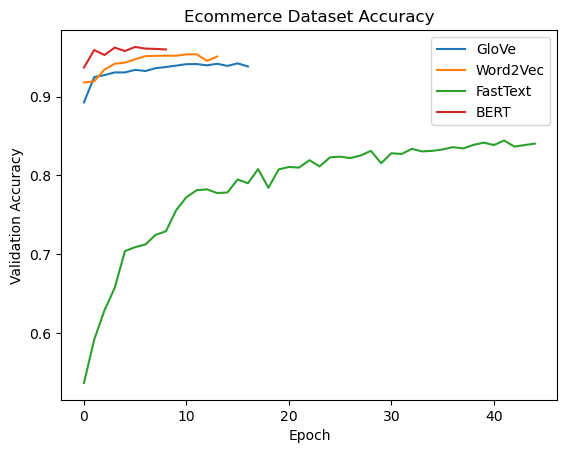

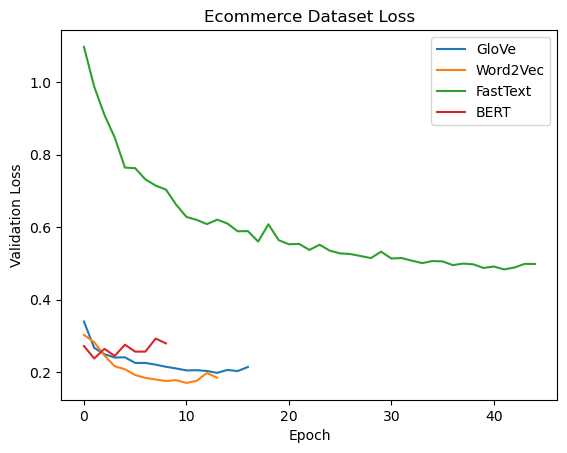

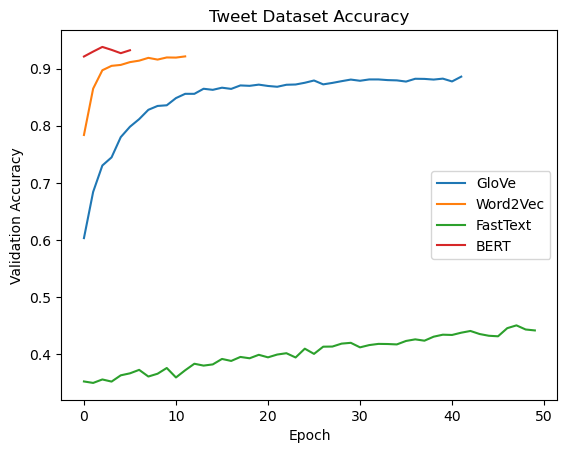

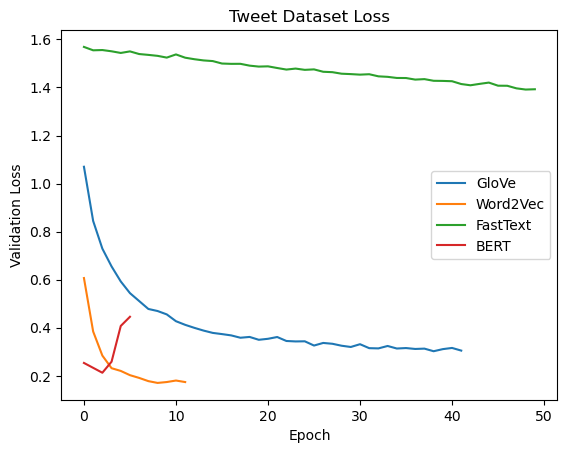

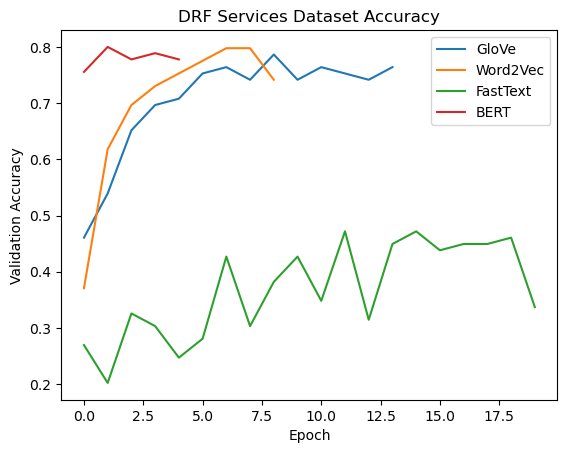

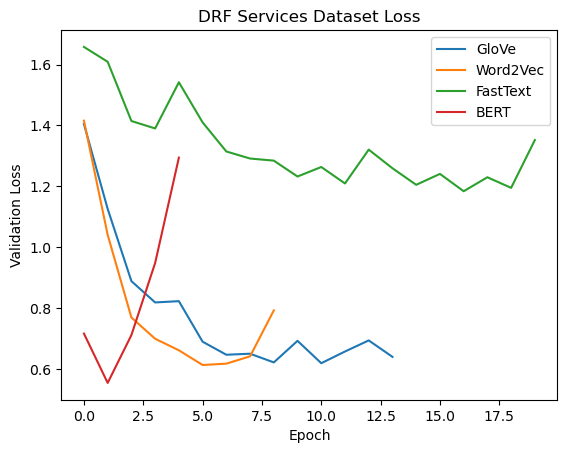

In [336]:
plt.plot(ecommerce_history_glove.history["val_accuracy"], label="GloVe")
plt.plot(ecommerce_history_word2vec.history["val_accuracy"], label="Word2Vec")
plt.plot(ecommerce_history_fasttext.history["val_accuracy"], label="FastText")
plt.plot(ecommerce_history_bert["val_accuracy"], label="BERT")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Ecommerce Dataset Accuracy")
plt.legend()
plt.show()

plt.plot(ecommerce_history_glove.history["val_loss"], label="GloVe")
plt.plot(ecommerce_history_word2vec.history["val_loss"], label="Word2Vec")
plt.plot(ecommerce_history_fasttext.history["val_loss"], label="FastText")
plt.plot(ecommerce_history_bert["val_loss"], label="BERT")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Ecommerce Dataset Loss")
plt.legend()
plt.show()

plt.plot(tweet_history_glove.history["val_accuracy"], label="GloVe")
plt.plot(tweet_history_word2vec.history["val_accuracy"], label="Word2Vec")
plt.plot(tweet_history_fasttext.history["val_accuracy"], label="FastText")
plt.plot(tweet_history_bert["val_accuracy"], label="BERT")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Tweet Dataset Accuracy")
plt.legend()
plt.show()

plt.plot(tweet_history_glove.history["val_loss"], label="GloVe")
plt.plot(tweet_history_word2vec.history["val_loss"], label="Word2Vec")
plt.plot(tweet_history_fasttext.history["val_loss"], label="FastText")
plt.plot(tweet_history_bert["val_loss"], label="BERT")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Tweet Dataset Loss")
plt.legend()
plt.show()

plt.plot(drf_history_glove.history["val_accuracy"], label="GloVe")
plt.plot(drf_history_word2vec.history["val_accuracy"], label="Word2Vec")
plt.plot(drf_history_fasttext.history["val_accuracy"], label="FastText")
plt.plot(drf_history_bert["val_accuracy"], label="BERT")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("DRF Services Dataset Accuracy")
plt.legend()
plt.show()

plt.plot(drf_history_glove.history["val_loss"], label="GloVe")
plt.plot(drf_history_word2vec.history["val_loss"], label="Word2Vec")
plt.plot(drf_history_fasttext.history["val_loss"], label="FastText")
plt.plot(drf_history_bert["val_loss"], label="BERT")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("DRF Services Dataset Loss")
plt.legend()
plt.show()

### Summary

*All models were trained with 20% validation split*

**Ecommerce Dataset**: 50,425 samples with average length ~700 characters

| Model    | Training Accuracy | Test Accuracy | Epochs |
| -------- | ----------------- | --------------| ------ |
| GloVe    | 0.9494            | 0.9383        | 17     |
| Word2Vec | 0.9680            | 0.9509        | 14     |
| FastText | 0.8550            | 0.8403        | 45     |
| BERT     | --                | 0.959899      | 9      |

**Tweet Dataset**: 21,405 samples with average length ~97 characters

| Model    | Training Accuracy | Test Accuracy | Epochs |
| -------- | ----------------- | ------------- | ------ |
| GloVe    | 0.8514            | 0.8858        | 42     |
| Word2Vec | 0.9517            | 0.9212        | 12     |
| FastText | 0.4585            | 0.4419        | 50     |
| BERT     | --                | 0.931966      | 6      |

**DRF Services Dataset**: 449 samples with average length ~199 characters

| Model    | Training Accuracy | Test Accuracy | Epochs |
| -------- | ----------------- | ------------- | ------ |
| GloVe    | 0.9028            | 0.7640        | 14     |
| Word2Vec | 0.9167            | 0.7416        | 9      |
| FastText | 0.5111            | 0.3371        | 20     |
| BERT     | --                | 0.777778      | 5      |